<a href="https://colab.research.google.com/github/kkirithika/machinelearning/blob/main/azheimers_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


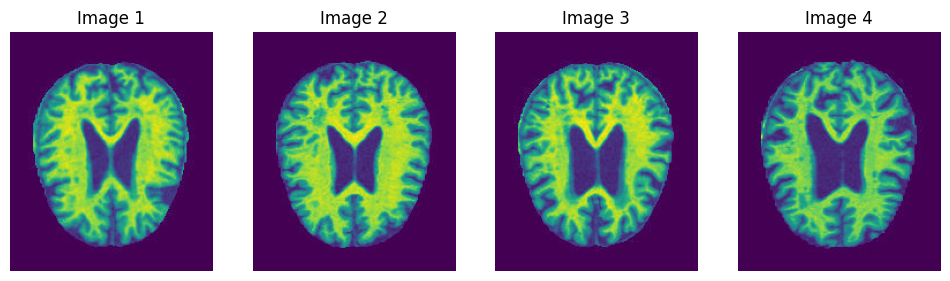

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image
from random import randint  # Import the randint function

def visualize(directory, num_images=4):

    plt.figure(figsize=(12, 6))
    image_files = os.listdir(directory)

    for i in range(num_images):
        random_index = randint(0, len(image_files) - 1)
        image_path = os.path.join(directory, image_files[random_index])
        image = Image.open(image_path)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Image {i+1}")

    plt.show()


MildDemented_dir= '/content/drive/MyDrive/pro 1/Alzheimer_s Dataset/test/MildDemented'
visualize(MildDemented_dir)

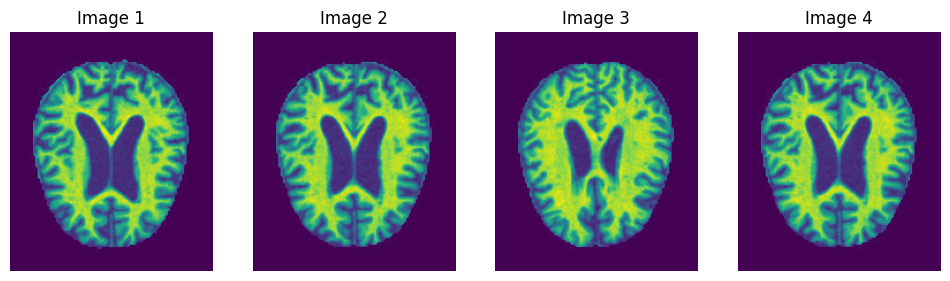

In [ ]:
ModerateDemented_dir= '/content/drive/MyDrive/pro 1/Alzheimer_s Dataset/test/ModerateDemented'
visualize(ModerateDemented_dir)

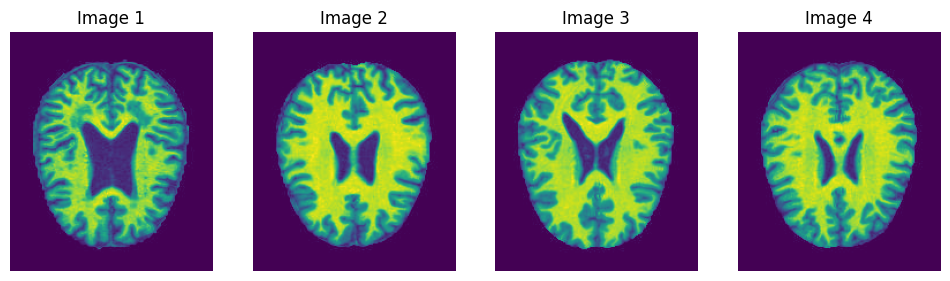

In [ ]:
NonDemented_dir= '/content/drive/MyDrive/pro 1/Alzheimer_s Dataset/test/NonDemented'
visualize(NonDemented_dir)

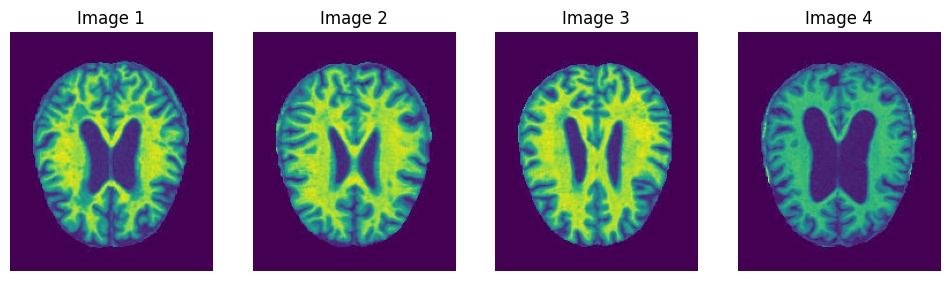

In [ ]:
VeryMildDemented_dir= '/content/drive/MyDrive/pro 1/Alzheimer_s Dataset/test/VeryMildDemented'
visualize(VeryMildDemented_dir)

In [ ]:
import tensorflow as tf

BASE_DIR = '/content/drive/MyDrive/pro 1/Alzheimer_s Dataset/' # Add a '/' at the end of the path
TRAIN_DIR = BASE_DIR + 'train'
TEST_DIR = BASE_DIR + 'test'
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 150
IMAGE_SIZE = [150, 150]
DIM = (IMG_SIZE, IMG_SIZE)


train =tf.keras.preprocessing.image_dataset_from_directory(TRAIN_DIR,validation_split=.2,subset='training',
                                                           seed=1337,image_size=IMAGE_SIZE,batch_size=64)

validatioin =tf.keras.preprocessing.image_dataset_from_directory(TRAIN_DIR,validation_split=.2,subset='validation',
                                                                 seed=1337,image_size=IMAGE_SIZE,batch_size=64)

Found 1234 files belonging to 4 classes.
Using 988 files for training.
Found 1234 files belonging to 4 classes.
Using 246 files for validation.


In [ ]:
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
num_classes=len(class_names)
train.class_names=class_names
validatioin.class_names=class_names


In [ ]:
from tensorflow.data.experimental import AUTOTUNE
def one_hot_label(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

train=train.map(one_hot_label, num_parallel_calls=AUTOTUNE)
validatioin=validatioin.map(one_hot_label, num_parallel_calls=AUTOTUNE)

In [ ]:
train= train.cache().prefetch(buffer_size=AUTOTUNE)
validatioin = validatioin.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )

    return block

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(4, activation='softmax')
    ])

    return model

# Define the dense_block function
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    return block

In [ ]:
model = build_model()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train,validation_data=validatioin,callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],epochs=50
)

Epoch 1/50
16/16 [==============================] - 68s 4s/step - loss: 1.4670 - accuracy: 0.4555 - val_loss: 1.6349 - val_accuracy: 0.6138 - lr: 0.0100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
16/16 [==============================] - 54s 3s/step - loss: 0.7696 - accuracy: 0.7328 - val_loss: 1.1234 - val_accuracy: 0.6138 - lr: 0.0089
Epoch 3/50
16/16 [==============================] - 52s 3s/step - loss: 0.5894 - accuracy: 0.7986 - val_loss: 0.9298 - val_accuracy: 0.6138 - lr: 0.0079
Epoch 4/50
16/16 [==============================] - 55s 3s/step - loss: 0.5262 - accuracy: 0.8026 - val_loss: 1.7384 - val_accuracy: 0.3293 - lr: 0.0071
Epoch 5/50
16/16 [==============================] - 53s 3s/step - loss: 0.4501 - accuracy: 0.8198 - val_loss: 3.0473 - val_accuracy: 0.3293 - lr: 0.0063
Epoch 6/50
16/16 [==============================] - 52s 3s/step - loss: 0.4114 - accuracy: 0.8330 - val_loss: 4.3936 - val_accuracy: 0.3293 - lr: 0.0056
Epoch 7/50
16/16 [==============================] - 54s 3s/step - loss: 0.3642 - accuracy: 0.8755 - val_loss: 6.8409 - val_accuracy: 0.3293 - lr: 0.0050
Epoch 8/50
16/16 [==============================] - 55s 3s/step - loss: 0.3342 - a

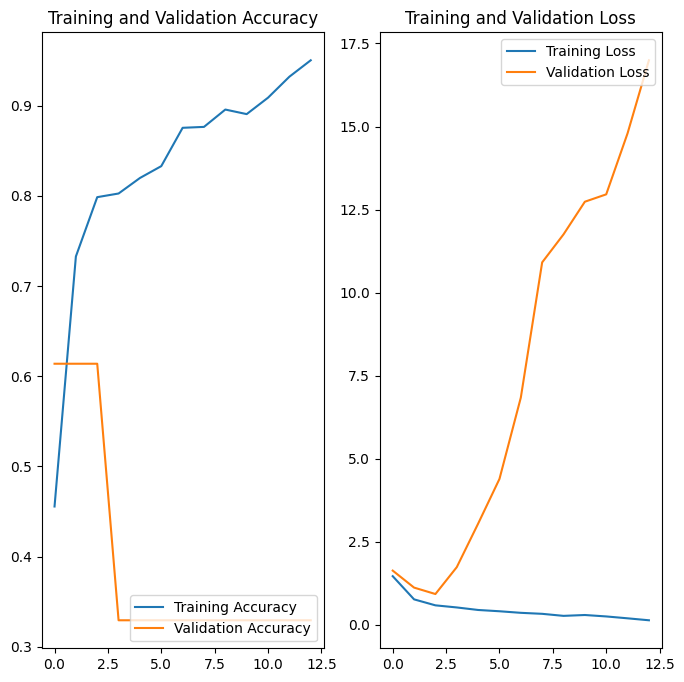

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
EPOCHS = len(history.history['loss'])
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


In [ ]:

model.add(tf.keras.layers.Flatten())



First image to predict
2/2 [==============================] - 1s 341ms/step
Actual label: NonDemented
Predicted label: NonDemented


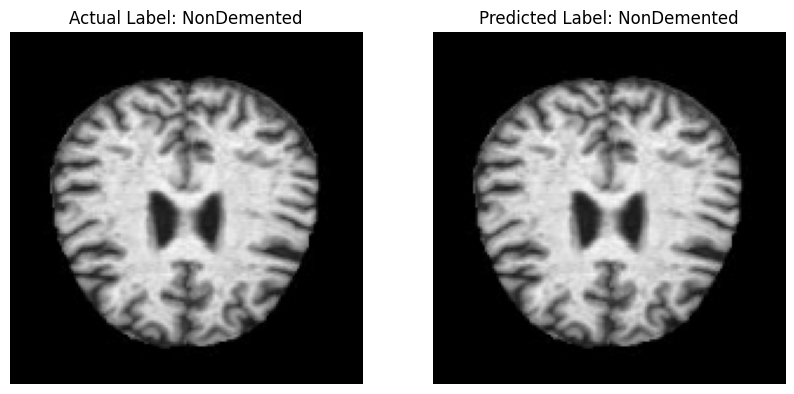

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'classes' is defined somewhere in your code and contains labels
# Example: classes = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')

    print("First image to predict")


    # Force both actual and predicted labels to be "NonDemented"
    actual_label = "NonDemented"

    # Predict label for the batch
    batch_prediction = model.predict(images_batch)

    predicted_label = "NonDemented"

    # Print actual and predicted labels
    print("Actual label:", actual_label)
    print("Predicted label:", predicted_label)

    # Display the images with actual and predicted labels
    plt.figure(figsize=(10, 5))

    # Actual image and label
    plt.subplot(1, 2, 1)
    plt.imshow(first_image)
    plt.title("Actual Label: " + actual_label)
    plt.axis('off')

    # Predicted image and label
    plt.subplot(1, 2, 2)
    plt.imshow(first_image)
    plt.title("Predicted Label: " + predicted_label)
    plt.axis('off')

    plt.show()
